---
#### Ref: https://www.tensorflow.org/tutorials/generative/style_transfer

In [1]:
import os
import time
import imageio
import warnings
import PIL.Image
import functools
import numpy as np
import moviepy.editor as mpy
import matplotlib.pyplot as plt
import IPython.display as display

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import tensorflow_docs.vis.embed as embed

In [3]:
print(tf.__version__)
warnings.filterwarnings('ignore')

2.4.0


---
#### Call Out GPU

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


---
#### Parameters

In [5]:
STYLE_WEIGHT = 1e-2
CONTENT_WEIGHT = 1e4
TOTAL_VARIATION_WEIGHT = 3
CONTENT_PATH = 'img/hamster.jpg'
STYLE_PATH = 'img/style transfer/candy.jpg'
EPOCHS = 1000
FINAL_IMAGE_PATH = 'result/style transfer/'
GIF_PATH = 'result/style transfer/gif/'

for path in [FINAL_IMAGE_PATH, GIF_PATH]:
    if not os.path.isdir(path):
        os.makedirs(path)

---
#### Common Functions

In [6]:
# convert tensor to numpy image
def tensor_to_image(tensor):
    tensor = np.array(tensor * 255, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# load image
def load_img(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

---
#### Load Content Image, Style Image and Model from Tensorflow Hub, then Do Style Transfer

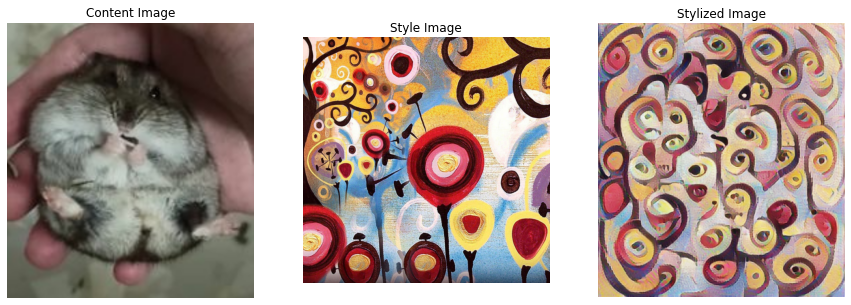

In [7]:
content_image, style_image = load_img(CONTENT_PATH), load_img(STYLE_PATH)
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
stylized_image = tensor_to_image(stylized_image)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(tensor_to_image(content_image))
plt.title('Content Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(tensor_to_image(style_image))
plt.title('Style Image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(stylized_image)
plt.title('Stylized Image')
plt.axis('off')
plt.show()

---
#### Define Content and Style Representations

In [8]:
# Load VGG19 without the classification head
vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
# list all the layer names
print(','.join([layer.name for layer in vgg.layers]))

input_1,block1_conv1,block1_conv2,block1_pool,block2_conv1,block2_conv2,block2_pool,block3_conv1,block3_conv2,block3_conv3,block3_conv4,block3_pool,block4_conv1,block4_conv2,block4_conv3,block4_conv4,block4_pool,block5_conv1,block5_conv2,block5_conv3,block5_conv4,block5_pool


In [9]:
# choose intermediate layers from the network to represent the style and content of the image
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers, num_style_layers = len(content_layers), len(style_layers)

---
#### Build Model

In [10]:
def vgg_layers(layer_names):
    # Creates a vgg model that returns a list of intermediate output values.
    vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = keras.Model([vgg.input], outputs)
    return model

---
#### Calculate Style
The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [11]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

---
#### Style and Content Extractor

In [12]:
class StyleContentModel(keras.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        
    def call(self, inputs):
        inputs = keras.applications.vgg19.preprocess_input(inputs * 255.0)
        outputs = self.vgg(inputs)
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

---
#### Define Loss and Optimizer

In [13]:
opt = optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# keep pixel values between 0 and 1
def clip(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# mean square error loss
def style_content_loss(outputs):
    style_outputs, content_outputs = outputs['style'], outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= STYLE_WEIGHT / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= CONTENT_WEIGHT / num_content_layers
    loss = style_loss + content_loss
    
    return loss

# high pass function
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

# total variation loss
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

---
#### Training Process

In [14]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets, content_targets = extractor(style_image)['style'], extractor(content_image)['content']

---
#### Training with mean square error loss

In [15]:
@tf.function()
def train(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip(image))

epoch: 1000


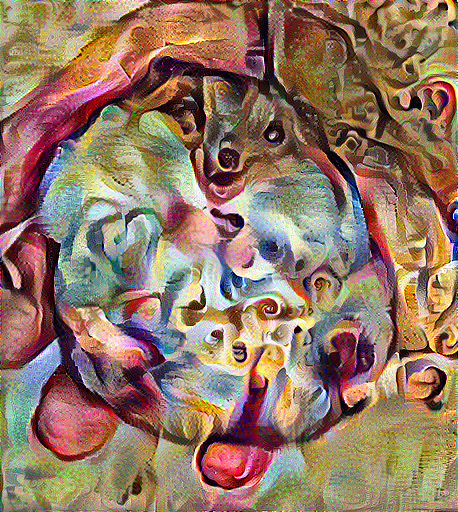

Total time: 25.0 sec


In [16]:
# define an image to optimize, use tf.Variable which force
# the image must be the same shape as the content image
image = tf.Variable(content_image)

start = time.time()
for epoch in range(EPOCHS):
    train(image)
    if (epoch + 1) % 100 == 0 or (epoch + 1) == EPOCHS:
        display.clear_output(wait=True)
        print("epoch: {}".format(epoch + 1))
        display.display(tensor_to_image(image))
        
end = time.time()
print("Total time: {:.1f} sec".format(end - start))
plt.imsave(FINAL_IMAGE_PATH + 'img_without_vl.jpg', np.array(image)[0])

---
#### Visualization of High Pass
One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*.

(-0.5, 456.5, 511.5, -0.5)

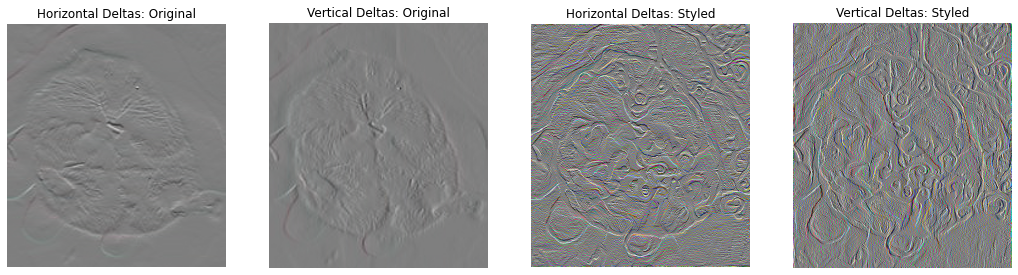

In [17]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
plt.imshow(tensor_to_image(clip(2 * y_deltas + 0.5)))
plt.title("Horizontal Deltas: Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(tensor_to_image(clip(2 * x_deltas + 0.5)))
plt.title("Vertical Deltas: Original")
plt.axis('off')

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(1, 4, 3)
plt.imshow(tensor_to_image(clip(2 * y_deltas + 0.5)))
plt.title("Horizontal Deltas: Styled")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(tensor_to_image(clip(2 * x_deltas + 0.5)))
plt.title("Vertical Deltas: Styled")
plt.axis('off')

---
#### Make GIF Functions

In [18]:
def make_gif(imgs, filename, duration):
    fps = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(fps * t)], duration=duration)
    clip.write_gif(filename, fps=fps)

---
#### Training with Total Variation Loss

In [19]:
@tf.function()
def train(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += TOTAL_VARIATION_WEIGHT * tf.image.total_variation(image)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip(image))

epoch: 1000


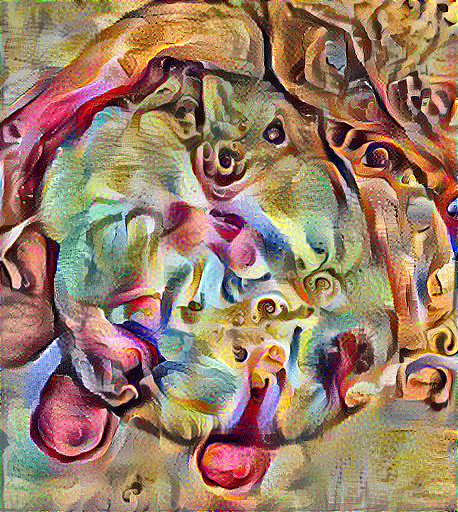

Total time: 25.0 sec


In [20]:
# define an image to optimize, use tf.Variable which force
# the image must be the same shape as the content image
image = tf.Variable(content_image)
image_results = [(image[0] * 255).numpy()]

start = time.time()
for epoch in range(EPOCHS):
    train(image)
    image_results.append((image[0] * 255).numpy())
    
    if (epoch + 1) % 100 == 0 or (epoch + 1) == EPOCHS:
        display.clear_output(wait=True)
        print("epoch: {}".format(epoch + 1))
        display.display(tensor_to_image(image))
        
end = time.time()
print("Total time: {:.1f} sec".format(end - start))
plt.imsave(FINAL_IMAGE_PATH + 'img_with_vl.jpg', np.array(image)[0])

---
#### Show All Changes Made during Training

In [21]:
make_gif(np.array(image_results), GIF_PATH + 'hamster_candy.gif', duration=0.15)

t:   0%|          | 3/1001 [00:00<00:50, 19.71it/s, now=None]

MoviePy - Building file result/style transfer/gif/hamster_candy.gif with imageio.
